In [85]:
import numpy as np
import pandas as pd
import os
import dtreeviz

import seaborn as sns
import matplotlib.pyplot as plt
import scipy as sc

from sklearn import tree
from sklearn.model_selection import train_test_split, StratifiedKFold, KFold, RandomizedSearchCV
from sklearn.metrics import precision_score, recall_score, accuracy_score,f1_score, make_scorer
from sklearn.metrics import confusion_matrix, classification_report

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

dsHotelsTest = pd.read_csv('hotels_test.csv')
dsHotelsTestCopy = dsHotelsTest.copy()
dsCHP1 = pd.read_csv('dsHotelCHP1.csv')
dsCHP1Copy = dsCHP1.copy()

# Feature Engeneering (Transfomraciones)

In [86]:
dsCHP1Copy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53944 entries, 0 to 53943
Data columns (total 30 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   hotel                           53944 non-null  object 
 1   lead_time                       53944 non-null  int64  
 2   arrival_date_year               53944 non-null  int64  
 3   arrival_date_month              53944 non-null  object 
 4   arrival_date_week_number        53944 non-null  int64  
 5   arrival_date_day_of_month       53944 non-null  int64  
 6   stays_in_weekend_nights         53944 non-null  int64  
 7   stays_in_week_nights            53944 non-null  int64  
 8   adults                          53944 non-null  int64  
 9   children                        53944 non-null  float64
 10  babies                          53944 non-null  int64  
 11  meal                            53944 non-null  object 
 12  country                         

In [87]:
dsHotelsTestCopy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26535 entries, 0 to 26534
Data columns (total 31 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   hotel                           26535 non-null  object 
 1   lead_time                       26535 non-null  int64  
 2   arrival_date_year               26535 non-null  int64  
 3   arrival_date_month              26535 non-null  object 
 4   arrival_date_week_number        26535 non-null  int64  
 5   arrival_date_day_of_month       26535 non-null  int64  
 6   stays_in_weekend_nights         26535 non-null  int64  
 7   stays_in_week_nights            26535 non-null  int64  
 8   adults                          26535 non-null  int64  
 9   children                        26535 non-null  float64
 10  babies                          26535 non-null  int64  
 11  meal                            26535 non-null  object 
 12  country                         

## Transformacion de atributos categoricos
Aquellos atributos categoricos que tienen demasiados valores unicos como 'country', vamos a reemplazarlo con un nuevo campo que simplemente tenga los 10 valores mas frecuentes (incluyendo el valor de Otros).
Aplicamos One Hot Encoding a dichas variables

### Para la variable 'country'

In [88]:
dsCHP1Copy['country'] = dsCHP1Copy['country'].where(        #Lo hacemos para el dataframe preprocesado en train
dsCHP1Copy['country'].isin(dsCHP1Copy['country'].value_counts().nlargest(10).index), 'Others')

dsHotelsTestCopy['country'] =dsHotelsTestCopy['country'].where(        #Lo hacemos para test
dsHotelsTestCopy['country'].isin(dsHotelsTestCopy['country'].value_counts().nlargest(10).index), 'Others')

### Para la variable 'agent'

In [89]:
dsCHP1Copy['agent'] = dsCHP1Copy['agent'].where(                #Lo hacemos para el dataframe preprocesado en train
dsCHP1Copy['agent'].isin(dsCHP1Copy['agent'].value_counts().nlargest(10).index), 'Others')

dsHotelsTestCopy['agent'] =dsHotelsTestCopy['agent'].where(        #Lo hacemos para test
dsHotelsTestCopy['agent'].isin(dsHotelsTestCopy['agent'].value_counts().nlargest(10).index), 'Others')

### Drops de columns
Dropeamos la columna id de ambos dataframes, ya que no aportan nada al analisis. Ademas sacamos la columna reservation_status_date del test ya que no esta en el train y es un error

In [90]:
dsCHP1Copy =  dsCHP1Copy.drop('id', axis=1)

In [91]:
dsHotelsTestCopy = dsHotelsTestCopy.drop('id', axis=1)
dsHotelsTestCopy = dsHotelsTestCopy.drop('reservation_status_date', axis=1)

### One Hot Encoding

In [92]:
ds_variables_categoricas = dsCHP1Copy.select_dtypes(include=['object'])
dsCHP1Copy = pd.get_dummies(dsCHP1Copy, columns=ds_variables_categoricas.columns.to_list(), drop_first=True)
dsHotelsTestCopy = pd.get_dummies(dsHotelsTestCopy, columns=ds_variables_categoricas.columns.to_list(), drop_first=True)
dsCHP1Copy['id'] = dsCHP1['id']

In [93]:
dsHotelsTestCopy.shape

(26535, 87)

In [94]:
dsCHP1Copy.shape

(53944, 85)

Dado que hay valores que estan en el train y que no estan en el test y viceversa busco que quedarme solo con las columnas que tengan en comun y al dataframe de train le agrego la columna target que sabemos que no esta en el test

In [95]:
categoriasEnComun = (dsCHP1Copy.columns).intersection(dsHotelsTestCopy.columns)
dsCHP1CopyY = dsCHP1Copy['is_canceled'].copy()
dsHotelsTestCopy = dsHotelsTestCopy[categoriasEnComun]
dsCHP1Copy = dsCHP1Copy[categoriasEnComun]
dsCHP1Copy['is_canceled'] = dsCHP1CopyY

Corroboro que ambos dataframes, test y train tengan la misma forma, es decir, las mismas columnas luego de las tranformaciones

In [96]:
if dsCHP1Copy.columns.tolist() == dsHotelsTestCopy.columns.tolist():
    print("Los DataFrames tienen las mismas columnas.")
else:
    print("Los DataFrames no tienen las mismas columnas.")

Los DataFrames no tienen las mismas columnas.


# Entrenamiento y prediccion

In [97]:
#Creo un dataset con los features que voy a usar para clasificar
dsCHP1CopyX = dsCHP1Copy.drop(['is_canceled'], axis='columns', inplace=False)

#Creo un dataset con la variable target
dsCHP1CopyY = dsCHP1Copy['is_canceled'].copy()

#Genero un conjunto de train a partir del dataframe de train
xTrain, xTest, yTrain, yTest = train_test_split(dsCHP1CopyX,
                                              dsCHP1CopyY,
                                              test_size=0.3,
                                              random_state=243)

## Creacion de clasificador de hiperparametros

In [98]:
treeModel = tree.DecisionTreeClassifier(criterion='entropy',
                                        max_depth=20,
                                        min_samples_leaf=10)
#Entrenamiento
model = treeModel.fit(X= xTrain, y= yTrain)

In [99]:
yPredicted = model.predict(xTest)
#Valores predichos
yPredicted

array([0, 0, 1, ..., 1, 1, 0], dtype=int64)

In [100]:
#Valores reales
yTest.values

array([0, 0, 1, ..., 1, 1, 1], dtype=int64)

## Matriz de confusion y metricas

### Matriz de confusion

Text(50.722222222222214, 0.5, 'True')

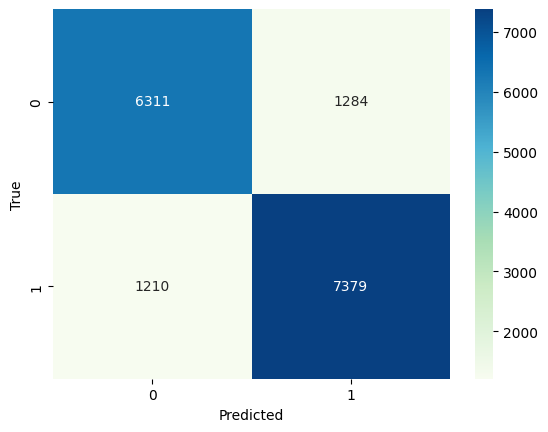

In [101]:
tabla = confusion_matrix(yTest, yPredicted)

sns.heatmap(tabla, cmap='GnBu', annot=True, fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')

### Metricas

In [102]:
#Calculo las métricas en el conjunto de evaluación
accuracy=accuracy_score(yTest,yPredicted)
recall=recall_score(yTest,yPredicted)
f1=f1_score(yTest,yPredicted,)
precision=precision_score(yTest,yPredicted)

print("Accuracy: "+str(accuracy))
print("Recall: "+str(recall))
print("Precision: "+str(precision))
print("f1 score: "+str(f1))

Accuracy: 0.8458971824023727
Recall: 0.8591221329607638
Precision: 0.8517834468428951
f1 score: 0.8554370507767216


# Primer submission a Kaggle

In [103]:
treeModel = tree.DecisionTreeClassifier(criterion='entropy',
                                        max_depth=20,
                                        min_samples_leaf=10)
#Entrenamiento
model = treeModel.fit(X= dsCHP1CopyX, y= dsCHP1CopyY)

In [104]:
yPredictedKaggle = model.predict(dsHotelsTestCopy)
#Valores predichos
yPredictedKaggle

array([1, 1, 0, ..., 1, 0, 0], dtype=int64)

In [105]:
dsKaggle = pd.DataFrame(zip(dsHotelsTest['id'], yPredictedKaggle), columns=['id', 'is_canceled'])
dsKaggle.to_csv("dsKaggleMateo.csv",index=False)

# Segunda submission a Kaggle

## Eleccion de hiperparametros

In [106]:
dsCHP1CopyX = dsCHP1Copy.drop(['is_canceled'], axis='columns', inplace=False)
dsCHP1CopyY = dsCHP1Copy['is_canceled'].copy()

xTrain, xTest, yTrain, yTest = train_test_split(dsCHP1CopyX,
                                                dsCHP1CopyY,
                                                test_size=0.3,    
                                                random_state=243,
                                                stratify=dsCHP1CopyY)

#Verifico Cantidad de Datos en cada set
print('# Datos Entrenamiento: {}'.format(len(xTrain)))
print('# Datos Prueba: {}'.format(len(xTest)))

#Verifico como quedaron balanceados
for split_name, split in zip(['% Positivos Entrenamiento','% Positivos Prueba'],[yTrain,yTest]):
  print('{}: {:.3f}'.format(split_name,pd.Series(split).value_counts(normalize=True)[1]*100))

# Datos Entrenamiento: 37760
# Datos Prueba: 16184
% Positivos Entrenamiento: 52.105
% Positivos Prueba: 52.107


### KFOLD CV Random Search

In [122]:
def CV_random_search_f1_score_optimizer(nIter, nFolds, maxDepth, minSamplesLeaf):

    #Conjunto de parámetros que quiero usar
    params_grid = {'criterion':['gini','entropy'],
               'ccp_alpha':np.linspace(0,0.05,n),
               'max_depth':list(range(1,maxDepth)),
               'min_samples_leaf':list(range(1, minSamplesLeaf))}

    #Kfold estratificado
    kfoldcv = StratifiedKFold(n_splits=nFolds)

    #Clasificador
    base_tree = tree.DecisionTreeClassifier()

    #Metrica que quiero optimizar F1 Score
    scorer_fn = make_scorer(f1_score)

    #Random Search Cross Validation
    randomcv = RandomizedSearchCV(estimator=base_tree,
                              param_distributions = params_grid,
                              scoring=scorer_fn,
                              cv=kfoldcv,
                              n_iter=nIter,
                              random_state=200)

    #Busco los hiperparamtros que optimizan F1 Score
    randomcv.fit(xTrain,yTrain);
    print(randomcv.best_params_)
    print(randomcv.best_score_)
    return randomcv

Generamos iterativamente combinacion de los 4 parametros (numero de iteraciones, nFolds, maxDepth y minSamplesLeaf) para ver como se comporta random search y con que parametros se llega a un score interesante

In [112]:
for nIter in range(20, 40, 20):
    for nFolds in range(3, 6, 3):
        for maxDepth in range(10, 40, 10):
            for minSamplesLeaf in range(10, 40, 10):
                print(nIter, nFolds ,maxDepth ,minSamplesLeaf)
                CV_random_search_f1_score_optimizer(nIter, nFolds ,maxDepth ,minSamplesLeaf)

20 3 10 10
{'min_samples_leaf': 2, 'max_depth': 7, 'criterion': 'entropy', 'ccp_alpha': 0.004081632653061225}
0.7889816449890888
20 3 10 20
{'min_samples_leaf': 6, 'max_depth': 6, 'criterion': 'gini', 'ccp_alpha': 0.0020408163265306124}
0.8022564951756025
20 3 10 30
{'min_samples_leaf': 21, 'max_depth': 9, 'criterion': 'gini', 'ccp_alpha': 0.0030612244897959186}
0.8047710916453114
20 3 20 10
{'min_samples_leaf': 2, 'max_depth': 12, 'criterion': 'gini', 'ccp_alpha': 0.0020408163265306124}
0.8133423141768549
20 3 20 20
{'min_samples_leaf': 10, 'max_depth': 12, 'criterion': 'entropy', 'ccp_alpha': 0.0071428571428571435}
0.7875896340001646
20 3 20 30
{'min_samples_leaf': 2, 'max_depth': 9, 'criterion': 'entropy', 'ccp_alpha': 0.0}
0.8104832597225405
20 3 30 10
{'min_samples_leaf': 1, 'max_depth': 29, 'criterion': 'gini', 'ccp_alpha': 0.0030612244897959186}
0.8047710916453114
20 3 30 20
{'min_samples_leaf': 6, 'max_depth': 13, 'criterion': 'entropy', 'ccp_alpha': 0.0}
0.8483966499319341
20 

KeyboardInterrupt: 

De toda esta cantidad de muestras podemos ver algunos parametros que tuvieron un score interesante, entre ellos esta por ejemplo:
(40, 3 ,20, 20),
(40, 3 ,30, 20)
(40 ,3 ,30 ,30)
(40, 6 ,20 ,20)

In [113]:
CV_random_search_f1_score_optimizer(40,6,20,20)

{'min_samples_leaf': 4, 'max_depth': 14, 'criterion': 'entropy', 'ccp_alpha': 0.0}
0.849780621412819


In [117]:
CV_random_search_f1_score_optimizer(40,9,20,20)

{'min_samples_leaf': 4, 'max_depth': 14, 'criterion': 'entropy', 'ccp_alpha': 0.0}
0.8538538457044856


## Prediccion y Evaluacion del modelo con mejores hiperparametros

In [128]:
bestParams = CV_random_search_f1_score_optimizer(40,9,20,20).best_params_
arbol=tree.DecisionTreeClassifier().set_params(**bestParams)
arbol.fit(xTrain, yTrain)

{'min_samples_leaf': 4, 'max_depth': 14, 'criterion': 'entropy', 'ccp_alpha': 0.0}
0.8539151359913272


DecisionTreeClassifier(criterion='entropy', max_depth=14, min_samples_leaf=4)

F1-Score: 0.8560981098109811


Text(50.722222222222214, 0.5, 'True')

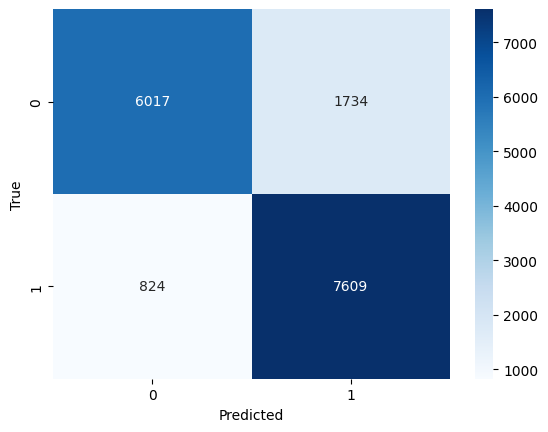

In [130]:
#Hago predicción sobre el set de evaluacion
yPred= arbol.predict(xTest)

#Arbol Reporte y Matriz de Confusion
#print(classification_report(y_test,y_pred))
print('F1-Score: {}'.format(f1_score(yTest, yPred, average='binary'))) #binary considera la clase positiva por defecto 1

cm = confusion_matrix(yTest,yPred)
sns.heatmap(cm, cmap='Blues',annot=True,fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')

## Prediccion con hotels_test.csv

In [131]:
treeModel = tree.DecisionTreeClassifier(**CV_random_search_f1_score_optimizer(40,9,20,20).best_params_)
#Entrenamiento
model = treeModel.fit(X= dsCHP1CopyX, y= dsCHP1CopyY)
yPredictedKaggle = model.predict(dsHotelsTestCopy)
#Valores predichos
yPredictedKaggle

{'min_samples_leaf': 4, 'max_depth': 14, 'criterion': 'entropy', 'ccp_alpha': 0.0}
0.8535858809644581


array([1, 1, 0, ..., 1, 1, 0], dtype=int64)

In [132]:
dsKaggle = pd.DataFrame(zip(dsHotelsTest['id'], yPredictedKaggle), columns=['id', 'is_canceled'])
dsKaggle.to_csv("dsKaggleConHiperparametros.csv",index=False)